## Background

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets for model exploration and building.

A synthetic dataset were generated using the simulator called PaySim. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.


## Goal
The goal of this analysis is to develop a generalized model to deal with **big and imblance data** prediction that suitable to real-world applications. The big data part was sloved by using the pysark.


### Data

The data of this project can be downloaded from [here](https://www.kaggle.com/ntnu-testimon/paysim1).

The explanation columns of input data:

**One row**: 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**Column names with explanition**: 

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.


The structure of the notebook is borrowed from [here](https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services) where they used pandas and sklearn to conduct the fraud detection. 

## Setup pyspark



In [1]:
import findspark
findspark.init()
findspark.find()

'/home/lplab/anaconda3/lib/python3.7/site-packages/pyspark'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

## 1 Import data

In [3]:
sc = SparkContext(appName="finicial fraud detection")
sc.setSystemProperty('spark.executor.memory', '64g')
sqlc = SQLContext(sc)

/home/lplab/anaconda3/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)
/home/lplab/anaconda3/lib/python3.7/site-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [4]:
## data
data_file = '/home/lplab/Desktop/210962206/BDAL PROJECT/archive/bank_data.csv'

In [5]:
data = sqlc.read.csv(data_file,header = True)

## 2 Data exploration

In [6]:
data.count()

6362620

In [7]:
data.dtypes

[('step', 'string'),
 ('type', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('isFraud', 'string'),
 ('isFlaggedFraud', 'string')]

In [8]:
data.limit(3).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0


In [9]:
data.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



**Tips:** We can see this is imblance data and we should use stratified split method in the following operation

In [10]:
### check if there is missing values in the data
from pyspark.sql.functions import col,sum
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### 2.1 Understand the data which belongs to fraudulent

In [11]:
subd = data.filter(data['isFraud'] == 1).groupby('type').count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



**Observation**: it looks only type is TRANSFER or CASH_OUT will be fraud.

In [12]:
data.groupby('isFlaggedFraud').count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(data_file)

print(df.isFraud.value_counts())
sns.countplot(y="isFraud",data=df)
plt.show()

0    6354407
1       8213
Name: isFraud, dtype: int64


<Figure size 640x480 with 1 Axes>

Observation: imbalanced

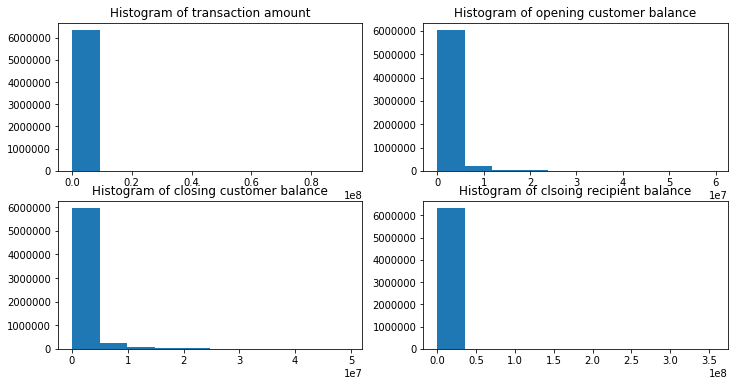

In [14]:
fig,axs = plt.subplots(2,2,figsize=(12,6))
axs[0][0].title.set_text('Histogram of transaction amount')
axs[0][0].hist(df["amount"])
axs[0][1].title.set_text("Histogram of opening customer balance")
axs[0][1].hist(df["oldbalanceOrg"])
axs[1][0].title.set_text("Histogram of closing customer balance")
axs[1][0].hist(df["newbalanceOrig"])
axs[1][1].title.set_text("Histogram of clsoing recipient balance")
axs[1][1].hist(df["newbalanceDest"])
plt.show()


Observation:
Secondly, there are very big outliers in the quantitative variables. Generally, very very big outliers are removed because there is a chance that it because of wrong recording. But in this case, wrong recording is not the case because very large frauds transactions tend to happen. So we cannot remove the outliers and there is a need of treating them before analysis or modelling.


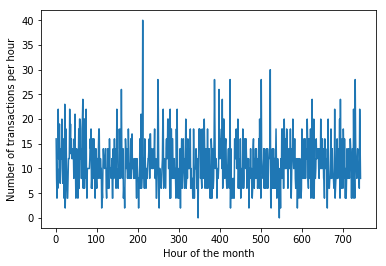

In [15]:
sns.lineplot(x=list(range(1,744)),y=df.groupby("step")["isFraud"].sum())
plt.xlabel("Hour of the month")
plt.ylabel("Number of transactions per hour")
plt.show()

Observation: One popular trend is fraud attacks by big criminals happen in a short period of time. In our data, we have data every hour. The below graph shows the fraud attack every hour in the 744 hours. As expected there are peaks and troughs and also a very big peak. This suggests that frauds happen in short period of time.

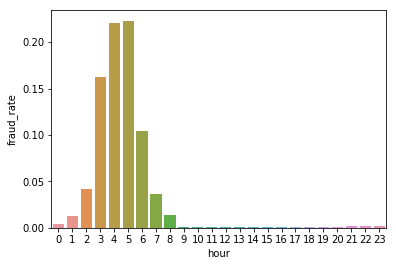

In [16]:
df["hour"] = df.step % 24
frauds_hour = pd.concat([df.groupby("hour")["isFraud"].sum(),df.groupby("hour")["isFraud"].count()],axis=1)
frauds_hour.columns = ["Frauds","Transactions"]
frauds_hour["fraud_rate"] = frauds_hour.Frauds/frauds_hour.Transactions
sns.barplot(x=frauds_hour.index,y=frauds_hour.fraud_rate)
plt.show()

Another analysis that can be interesting is at which hour of a day, the fraud attacks generally happen. From the step variable, we can get the hour of day. The below plot shows the frauds at different hours of day. It tells that frauds happen during sleeping hours the most. Close to 20% of transactions that happen during 4 AM and 5 AM are fraud transactions.

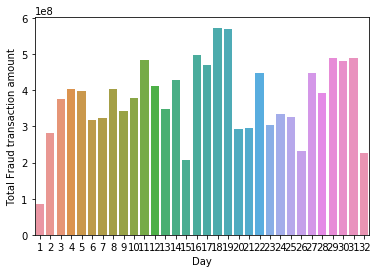

In [17]:
df["day"] = round(df.step/24)
sns.barplot(x=list(range(1,33)),y=df[df.isFraud==1].groupby("day")["amount"].sum())
plt.xlabel("Day")
plt.ylabel("Total Fraud transaction amount")
plt.show()

The below plot shows the total fraud transaction amount on a daily basis

### 2.2 Check if this is consistent with the decription of the column that more than 200,200 will be conisdered as illegal

In [18]:
data.filter(data['isFlaggedFraud'] == 1).orderBy('amount').show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 646|TRANSFER|     1.0E7|  C19004745|1.039904508E7| 1.039904508E7|C1806199534|           0.0|           0.0|      1|             1|
| 425|TRANSFER|     1.0E7| C689608084|1.958504037E7| 1.958504037E7|C1392803603|           0.0|           0.0|      1|             1|
| 730|TRANSFER|     1.0E7|C2140038573|1.731625505E7| 1.731625505E7|C1395467927|           0.0|           0.0|      1|             1|
| 250|TRANSFER|1343002.08|C1100582606|   1343002.08|    1343002.08|C1147517658|           0.0|           0.0|      1|             1|
| 617|TRANSFER|2542664.27| C786455622|   2542664.27|    2542664.27| C

### Check the min and max of the values when it's flagged as fraud

In [ ]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "max"}).collect()[0]
min1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "min"}).collect()[0]
print(min1,max1)

In [ ]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "mean"}).collect()[0]

In [ ]:
data.groupBy(['isFlaggedFraud']).agg({'amount':'avg','isFlaggedFraud':'count'}).show()

### Multiple columns and multiple functions

In [ ]:
from pyspark.sql.functions import mean, sum, max, col,count
groupBy = ["isFlaggedFraud"]
aggregate = ["amount"] 
funs = [mean, sum, max,count]

exprs = [f(col(c)) for f in funs for c in aggregate]

In [ ]:
re1 = data.groupby(*groupBy).agg(*exprs).collect()

In [ ]:
re1

In [ ]:
max0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "max"}).collect()[0]
min0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "min"}).collect()[0]

In [ ]:
max1[0],min1[0],max0[0],min0[0]

**Observations**: Once is flagged as fraud, the destination's account are always zero before and after transcation. It 
    made sense as the transcation will be halted when it's flagged as fraud.

In [ ]:
data.filter( (data['isFlaggedFraud'] == 0) & (data['oldbalanceDest'] ==0) & (data['newbalanceDest'] ==0)).show(5)

In [ ]:
### whether the account names is duplicated or not when it is flagged as fraud
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameOrig').count().show()

In [ ]:
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameDest').count().show()

### 2.3. Are expected merchant accounts accordingly labelled?
It was stated <a href='http://www2.bth.se/com/edl.nsf/pages/phd-dissertation'>[5]</a> that CASH_IN involves being paid by
a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have
merchants making CASH_IN transactions to customers.

In [ ]:
subd1 = data.filter( (data['type'] == 'CASH_IN') & \
                (data['nameOrig'].like('%M%')) ).show(4)

In [ ]:
subd1 = data.filter( (data['type'] == 'CASH_OUT') & \
                (data['nameOrig'].like('%M%')) ).show(4)

In [ ]:
data.filter(data['nameDest'].like('%M%')).groupBy('type').count().show()

In [ ]:
data.filter( (col('nameDest').isin(col('nameOrig'))) & (data['isFraud'] == 1)).show(5)

## 3 Data cleaning

In [ ]:
x0 = data.filter(data['type'].isin(['CASH_OUT','TRANSFER']))

In [ ]:
data.select(['type']).distinct().show()

##### Destination account - replace zero with -1

In [ ]:
### chang 0 to more sensible values for some cases
from pyspark.sql.functions import when
import numpy as np

x0 = x0.withColumn('oldbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['oldbalanceDest']))

x0 = x0.withColumn('newbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['newbalanceDest']))

In [ ]:
##check if the replacement working
##double check the results
x0.agg({"oldbalanceDest": "min"}).collect()[0]

#### Convert string to numeric columns

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
'''x0 is the data frame'''
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(x0) for column in ['type'] ]

pipeline = Pipeline(stages=indexers)
x_r = pipeline.fit(x0).transform(x0)

In [ ]:
x_r.limit(5).toPandas()

In [ ]:
from pyspark.sql.types import IntegerType

In [ ]:
xx = x_r.withColumn('type_index',x_r['type_index'].cast(IntegerType()))
xx = xx.withColumn('isFraud',x_r['isFraud'].cast(IntegerType()))

In [ ]:
xx = xx.withColumnRenamed('isFraud','label')

In [ ]:
xx.limit(5).toPandas()

In [ ]:
xf = xx.drop('type')

In [ ]:
xf.limit(5).toPandas()

## 4 Feature enginering

In [ ]:
from pyspark.sql.functions import col

In [ ]:
xf = xf.withColumn("errorbalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))

In [ ]:
xf = xf.withColumn("errorbalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))

In [ ]:
xf.limit(5).toPandas()

## convert data frame types

In [ ]:
yv = ['isFraud']
xv = ['step',
      'type_index',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]

In [ ]:
xf.dtypes

In [ ]:
sxv = ['step',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest']
for col_name in sxv:
    xf = xf.withColumn(col_name, col(col_name).cast('float'))

In [ ]:
xf.dtypes

## 5 Train and test data split

In [ ]:
from pyspark.sql.functions import lit

### stratified split

Here I used stratified split instead of random split which can overcome the imblance data problem.

In [ ]:
fractions = xf.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = xf.sampleBy('label',fractions,seed=17)
df_test = xf.subtract(df_train)

## 6 Model - pipeline

In [ ]:
yv = ['label']
xv = ['step','type_index','amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]

### 6.1 convert dataframe to vector

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols= xv, outputCol="va")

### 6.2 Creating PCA (when we have a lot of columns or features)

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="va", outputCol="features")

### 6.3 Create a Logistic Regression classifer

In [ ]:
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(labelCol="label", featuresCol="features")

### 6.4 Creating a Binary Classification Evaluator

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')  

### Creating  a Pipeline

This will be easier when we need to test different scenarios.

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, pca, log_reg])

In [ ]:
df_train.dtypes

In [ ]:
fit_model = pipeline.fit(df_train) 
results = fit_model.transform(df_test)

## Evalution of Model - Accuracy

In [ ]:
train_pred = fit_model.transform(df_train)
labels = 'label'
train_acc = evaluator.evaluate(train_pred)

test_pred = fit_model.transform(df_test)
test_acc = evaluator.evaluate(test_pred)

print('train_acc: {}, test_acc: {}'.format(train_acc, test_acc))

In [ ]:
# from sklearn.metrics import confusion_matrix
# preds = train_pred.select('prediction')
# labels = train_pred.select('label')

# cm = confusion_matrix(labels.rdd.take(6362620),preds.rdd.take(6362620))
# labels = ['True Neg','False Pos','False Neg','True Pos']
# labels = np.asarray(labels).reshape(2,2)
# sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
# print(cm)

# SVM

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=xv, outputCol="features")
labels ='label'
# Initialize the Linear SVC model
lsvc = LinearSVC(maxIter=8, regParam=0.1, featuresCol="features", labelCol=labels)  # Adjust hyperparameters as needed

# Define the pipeline
pipeline = Pipeline(stages=[assembler, lsvc])
model = pipeline.fit(df_train)

# Make predictions on test data
predictions = model.transform(df_test)

# Evaluate the model's accuracy or other metrics as required
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=labels)
train_pred = model.transform(df_train)
train_acc = evaluator.evaluate(train_pred)

accuracy = evaluator.evaluate(predictions)

print('train_acc: {}, test_acc: {}'.format(train_acc, accuracy))


In [ ]:
from sklearn.metrics import confusion_matrix
preds = train_pred.select('prediction')
labels = train_pred.select('label')

cm = confusion_matrix(labels.rdd.take(6362620),preds.rdd.take(6362620))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
print(cm)